# Computational Photonics
## Homework 0: Implementation of the Matrix Method
### Tasks
using the Matrix method to solve a Bragg mirror:

1. Transfer matrix: Compute $\hat{\textbf{M}}$
2. Reflection & transmission coefficients: Compute $r$, $t$, $R$, and $T$ as a function of wavelenght $\lambda$
3. Field distribution: Compute the complex field $F$ at predefined values of $x$
4. Time animation of the Field: visualize the temporal evolution of the flied.

### The Bragg mirror
1. A 10 layer mirror
2. for $\lambda = 780$ nm.
3. the mirror is made of layers $\epsilon_1 = 2.25$, $d_1 = 0.13$ $\mu\text{m}$ , and $\epsilon_2 = 15.21$, $d_2 = 0.05$ $\mu\text{m}$
4. The incident refractive index is 1 $n_{inc} = 1$
5. The transmitted refractive index is 1.5 $n_{out} = 1.5$
6. Polarization is TE
7. under normal incidence $\theta_{inc} = 0 $

# Solving Strategy:


In [7]:
"""
import the modules and packages required for the computation
"""
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

$$
k_z = \frac{\omega}{c}\sqrt{\epsilon_{in}}\cdot sin(\theta)=\frac{2\pi}{\lambda_0}\cdot sin(\theta)
$$
$\theta \rightarrow$ angle of incidence 

# 1. Transfer Matrix $\hat{\textbf{M}}$

## Function definitions
### Parameter generation for a Bragg stack

In [4]:
def bragg(n1, n2, d1, d2, N):
    '''Generates the stack parameters of a Bragg mirror
    The Bragg mirror starts at the incidence side with layer 1 and is
    terminated by layer 2

    Parameters
    ----------
    n1, n2 : float or complex
        Refractive indices of the layers of one period
    d1, d2 : float
        Thicknesses of layers of one period
    N  : in
        Number of periods

    Returns
    -------
    epsilon : 1d-array
        Vector containing the permittivities
    thickness : 1d-array
        Vector containing the thicknesses
    '''

    # find suitable type for epsilon
    dt = np.common_type(np.array([n1]), np.array([n2]))
    epsilon = np.zeros((2 * N,), dtype = dt)
    epsilon[::2] = n1**2
    epsilon[1::2] = n2**2
    thickness = np.zeros((2*N,))
    thickness[::2] = d1
    thickness[1::2] = d2
    return epsilon, thickness


### Transfer matrix for a stratified medium

In [5]:
def transfermatrix(thickness, epsilon, polarisation, wavelength, kz):
    '''Computes the transfer matrix for a given stratified medium.

    Parameters
    ----------
    thickness : 1d-array
        Thicknesses of the layers in µm.
    epsilon : 1d-array
        Relative dielectric permittivity of the layers.
    polarisation : str
        Polarisation of the computed field, either 'TE' or 'TM'.
    wavelength : float
        The wavelength of the incident light in µm.
    kz : float
        Transverse wavevector in 1/µm.

    Returns
    -------
    M : 2d-array
        The transfer matrix of the medium.
    '''
    # initialize system transfer matrix to identity matrix
    M = np.eye(2, dtype=np.complex128)

    # determine alpha, depending on the polarization
    if polarisation == 'TE':
        alpha = np.ones_like(epsilon)
    elif polarisation == 'TM':
        alpha = 1.0/epsilon
    else:
        raise ValueError('Invalid input: '
                         'polarisation must either be "TE" or "TM"')

    # vacuum wavenumber
    k0 = 2.0 * np.pi/wavelength
    # wave vector component normal to layer stack
    kx = np.sqrt(k0**2 * epsilon - kz**2, dtype=np.complex128)

    # iterate over layers
    for kxi, di, alphai in zip(kx, thickness, alpha):
        c = np.cos(kxi * di)
        s = np.sin(kxi * di)
        ka = kxi * alphai
        mi = np.array([[    c, s/ka],
                      [-ka * s,    c]])
        # left-sided multiplication: prepend new layer transfer matrix to system transfer matrix
        M = mi @ M

    return M


### Step 1: define and generate the parameters

In [10]:
n1 = np.sqrt(2.25)
n2 = np.sqrt(15.21)
d1 = 0.13
d2 = 0.05
N  = 5
epsilon, thickness = bragg(n1, n2, d1, d2, N)

wavelength = 0.78
kz = 0.0
polarisation = 'TE'
M = transfermatrix(thickness, epsilon, polarisation, wavelength, kz)

# print results: transfer matrix, determinant, eigenvector
print('M = {0}'.format(M))
print('det(M) = {0}'.format(np.linalg.det(M)))
print('eig(M) = {0}'.format(np.linalg.eig(M)[0]))


M = [[-8.41653357e-03+0.j  1.74080729e-15+0.j]
 [-6.60810742e-13+0.j -1.18813760e+02+0.j]]
det(M) = (1+0j)
eig(M) = [-8.41653357e-03+0.j -1.18813760e+02+0.j]


The transfer matrix at 780nm is:
$M = \pmatrix{-0.0084 & 0 \\
                0 & -188.8138}$
                
with $\det(M) = 1 + 0j$

and $\text{eig}(M) = \pmatrix{-0.0084 + 0j \\ -188.8138 + 0j}$

### Step 2: compute the transfer matrix | print results

# Reflection & Transmission coefficients

### The spectrum function:

In [12]:
def spectrum(thickness, epsilon, polarisation, wavelength, angle_inc,
             n_in, n_out):
    '''Computes the reflection and transmission of a stratified medium.

    Parameters
    ----------
    thickness : 1d-array
        Thicknesses of the layers in µm.
    epsilon : 1d-array
        Relative dielectric permittivity of the layers.
    polarisation : str
        Polarisation of the computed field, either 'TE' or 'TM'.
    wavelength : 1d-array
        The wavelength of the incident light in µm.
    angle_inc : float
        The angle of incidence in degree (not radian!).
    n_in, n_out : float
        The refractive indices of the input and output layers.

    Returns
    -------
    T : 1d-array
        Transmitted amplitude
    R : 1d-array
        Reflected amplitude
    tau : 1d-array
        Transmitted energy
    rho : 1d-array
        Reflected energy
    '''

    # Definition of the paramters of the input and output layers
    epsilon_in = n_in**2
    epsilon_out = n_out**2

    if polarisation == 'TE':
        alpha_in = 1
        alpha_out = 1
    elif polarisation == 'TM':
        alpha_in = 1/epsilon_in
        alpha_out = 1/epsilon_out
    else:
        raise ValueError('Invalid input: '
                          'polarisation must either be "TE" or "TM"')

    k0 = 2.0 * np.pi/wavelength # vacuum wavenumber
    kz = k0 * n_in * np.sin(np.deg2rad(angle_inc))
    kx_in = np.sqrt(epsilon_in * k0**2 - kz**2, dtype=np.complex128)
    kx_out = np.sqrt(epsilon_out * k0**2 - kz**2, dtype=np.complex128)

    R = np.zeros(wavelength.shape, dtype=np.complex128)
    N = np.zeros(wavelength.shape, dtype=np.complex128)

    # iterate over wavelengths
    for i, (lami, kzi, kx_outi, kx_ini) in enumerate(zip(wavelength, kz, kx_out, kx_in)):
        M = transfermatrix(thickness, epsilon, polarisation, lami, kzi)
        N[i] = (alpha_in * kx_ini * M[1,1] + alpha_out * kx_outi * M[0,0]
              + 1j * (M[1,0] - alpha_in * kx_ini * alpha_out * kx_outi * M[0,1]))
        R[i] = (alpha_in * kx_ini * M[1,1] - alpha_out * kx_outi * M[0,0]
              - 1j*(M[1,0] + alpha_in * kx_ini * alpha_out * kx_outi * M[0,1]))
    R /= N

    # calculate remaining coefficients
    T = 2.0*alpha_in*kx_in/N
    rho = np.real(R*np.conj(R))
    tau = np.real(alpha_out*kx_out)/np.real(alpha_in*kx_in)*np.real(T*np.conj(T))

    return T, R, tau, rho

### Compute a 10 layer Bragg stack

In [13]:
# Bragg mirror with 5 periods
epsilon, thickness = bragg(n1, n2, d1, d2, N)
n_in = 1
n_out = 1.5
angle_inc = 0
wavelength_vector = np.linspace(0.5, 1.5, 1001)
T, R, tau, rho = spectrum(thickness, epsilon, polarisation,
                          wavelength_vector, angle_inc, n_in, n_out)



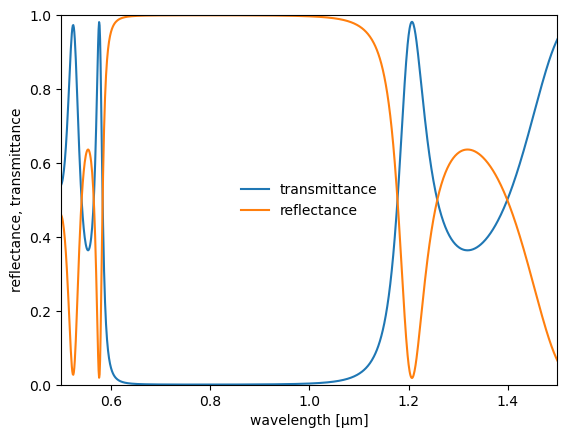

In [14]:
## plot reflectance and transmittance
plt.figure()
plt.plot(wavelength_vector, tau,
         wavelength_vector, rho)
plt.xlim(wavelength_vector[[0,-1]])
plt.ylim([0, 1])
plt.xlabel('wavelength [µm]')
plt.ylabel('reflectance, transmittance')
plt.legend(['transmittance', 'reflectance'], loc='center', frameon=False)



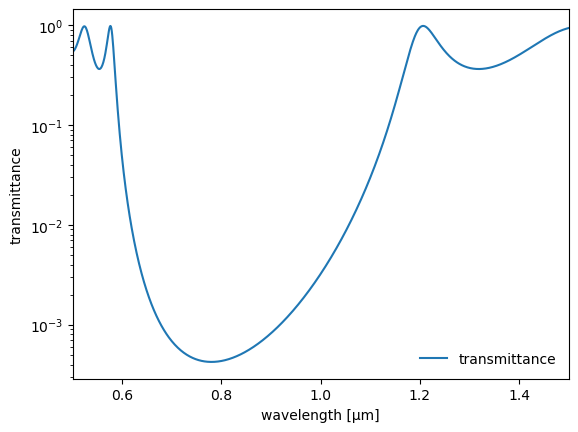

Maximum absorption: 2.5500435096859064e-15


In [15]:
## plot transmittance on log scale
plt.figure()
plt.semilogy(wavelength_vector, tau)
plt.xlim(wavelength_vector[[0,-1]])
plt.xlabel('wavelength [µm]')
plt.ylabel('transmittance')
plt.legend(['transmittance'], loc='lower right', frameon=False)
plt.show()

print('Maximum absorption: {0}'.format(np.abs(1 - tau - rho).max()))

## Extra: Fabry-Perot resonator
### Introducing a cavity to the stack

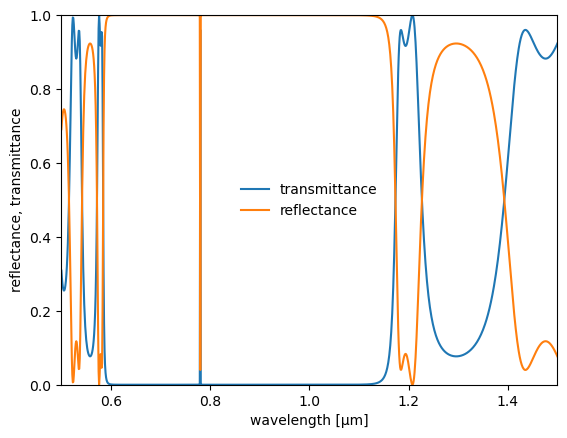

In [16]:
# redefine stack parameters: double the amount of layers
epsilon, thickness = bragg(n1,n2, d1, d2, 2*N)

# adding a cavity at the center of the stack
thickness[2*N] = 2*thickness[2*N]

# repeat the stack calculation
T, R, tau, rho = spectrum(thickness, epsilon, polarisation,
                          wavelength_vector, angle_inc, n_in, n_out)

## plot reflectance and transmittance
plt.figure()
plt.plot(wavelength_vector, tau,
         wavelength_vector, rho)
plt.xlim(wavelength_vector[[0,-1]])
plt.ylim([0, 1])
plt.xlabel('wavelength [µm]')
plt.ylabel('reflectance, transmittance')
plt.legend(['transmittance', 'reflectance'], loc='center', frameon=False)

# Calculating the Flied Distribution

Parameters:
other parameters are defined previously

In [17]:
Nsteps = 1000

### The field function

In [18]:
def field(thickness, epsilon, polarisation, wavelength, kz, n_in, n_out,
          Nx, l_in, l_out):
    '''Computes the field inside a stratified medium.

    The medium starts at x = 0 on the entrance side. The transmitted field
    has a magnitude of unity.

    Parameters
    ----------
    thickness : 1d-array
        Thicknesses of the layers in µm.
    epsilon : 1d-array
        Relative dielectric permittivity of the layers.
    polarisation : str
        Polarisation of the computed field, either 'TE' or 'TM'.
    wavelength : float
        The wavelength of the incident light in µm.
    kz : float
        Transverse wavevector in 1/µm.
    n_in, n_out : float
        The refractive indices of the input and output layers.
    Nx : int
        Number of points where the field will be computed.
    l_in, l_out : float
        Additional thickness of the input and output layers where the field
        will be computed.

    Returns
    -------
    f : 1d-array
        Field structure
    index : 1d-array
        Refractive index distribution
    x : 1d-array
        Spatial coordinates
    '''
    # Input layer for x < 0; and output layer for x > 0; illumination from the input side
    epsilon_in = n_in**2
    epsilon_out = n_out**2

    # extension of the vectors epsilon and thickness to take the input
    #  and output layers into account
    thickness = np.concatenate(([l_in], thickness, [l_out]))
    epsilon = np.concatenate(([epsilon_in], epsilon, [epsilon_out]))

    # flip layers (calculation proceeds backwars from the transmitted field)
    epsilon = epsilon[::-1]
    thickness = thickness[::-1]

    # determine alpha, depending on the polarization
    if polarisation == 'TE':
        alpha = np.ones_like(epsilon)
    elif polarisation == 'TM':
        alpha = 1.0/epsilon
    else:
        raise ValueError('Invalid input: '
                         'polarisation must either be "TE" or "TM"')

    # vacuum wavenumber
    k0 = 2.0 * np.pi/wavelength
    # wave vector component normal to layer stack
    kx = np.sqrt(epsilon*k0**2 - kz**2, dtype=np.complex128)

    # output layer parameters
    alpha_out = alpha[0]
    kx_out = kx[0]

    # further computation starts from the transmitted field because the fields
    # are calculated from the back
    incident_vec = np.array([[1.0], [-1.0j * alpha_out * kx_out]])

    # definition of output positions
    x = np.linspace(0, np.sum(thickness), Nx)

    # initialization of loop variables
    curr_layer = 0
    pos_in_layer = 0.0
    thickness_below = 0.0
    M = np.eye(2, dtype=np.complex128)
    f = np.zeros(x.shape, dtype=np.complex128)
    index = np.zeros(x.shape, dtype=epsilon.dtype)

    for i, xi in enumerate(x):
        # get postion within current layer
        pos_in_layer = xi - thickness_below

        # check if a layer interface has been crossed
        if pos_in_layer > thickness[curr_layer]:
            # propagate until layer interface
            c = np.cos(kx[curr_layer] * thickness[curr_layer])
            s = np.sin(kx[curr_layer] * thickness[curr_layer])
            ka = kx[curr_layer] * alpha[curr_layer]
            m = np.array([[    c, s/ka],
                          [-ka*s,    c]])
            # update transfer matrix
            M = m @ M
            # update state variables
            pos_in_layer = pos_in_layer - thickness[curr_layer]
            thickness_below = thickness_below + thickness[curr_layer]
            curr_layer += 1

        # propagate within layer to current position
        c = np.cos(kx[curr_layer] * pos_in_layer)
        s = np.sin(kx[curr_layer] * pos_in_layer)
        ka = kx[curr_layer] *  alpha[curr_layer]
        m = np.array([[    c, s/ka],
                      [-ka * s,    c]])
        out_vector = m @ M @ incident_vec
        f[i] = out_vector[0,0]
        index[i] = np.sqrt(epsilon[curr_layer])

    # at the end, the fields have to be flipped
    f = f[::-1]
    index = index[::-1]

    return f, index, x

### Results

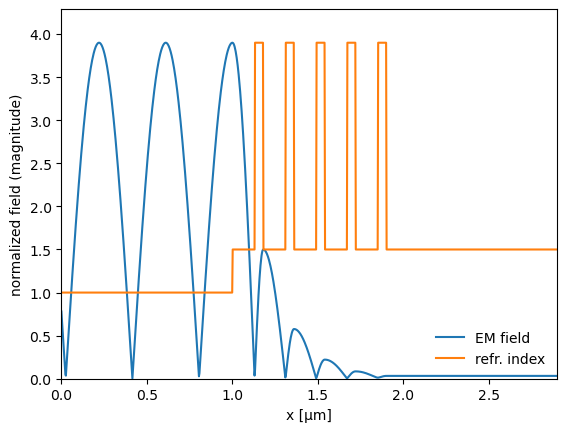

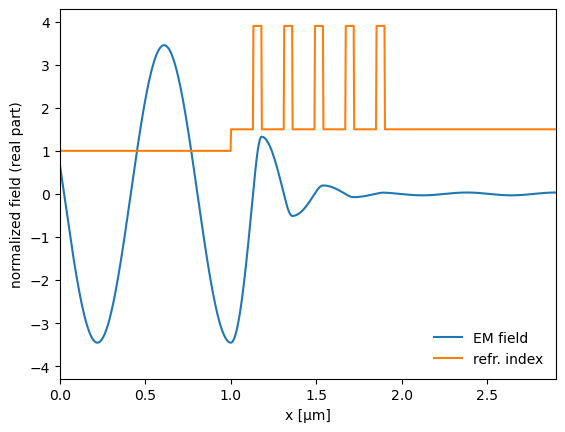

In [19]:
# bragg mirror
epsilon, thickness = bragg(n1, n2, d1, d2, N)
l_in = 1.0
l_out = 1.0
Nx = 1000
wavelength = 0.78
kz = 0
f, index, x = field(thickness, epsilon, polarisation, wavelength, kz,
                    n_in ,n_out, Nx, l_in, l_out)

## plot magnitude of field
plt.figure()
plt.plot(x, np.abs(f)/np.abs(f).max()*index.real.max(),
         x, index.real)
plt.xlim(x[[0,-1]])
plt.ylim([0, 1.1*index.real.max()])
plt.xlabel('x [µm]')
plt.ylabel('normalized field (magnitude)')
plt.legend(['EM field', 'refr. index'], loc='lower right', frameon=False)

## plot real part of field
plt.figure()
plt.plot(x, f.real/np.abs(f).max()*index.real.max(),
         x, index.real)
plt.xlim(x[[0,-1]])
plt.ylim(np.array([-1.1, 1.1])*index.real.max())
plt.xlabel('x [µm]')
plt.ylabel('normalized field (real part)')
plt.legend(['EM field', 'refr. index'], loc='lower right', frameon=False)
plt.show()

In [20]:
from matplotlib import animation

In [21]:
def timeanimation(x, f, index, steps, periods):
    ''' Animation of a quasi-stationary field.

    Parameters
    ----------
    x : 1d-array
        Spatial coordinates
    f : 1d-array
        Field
    index : 1d-array
        Refractive index
    steps : int
        Total number of time points
    periods : int
        Number of the oscillation periods.

    Returns
    -------
    ani : matplotlib.animation.FuncAnimation
        The time animation of the field
    '''
    # based on https://matplotlib.org/gallery/animation/simple_anim.html

    freq = periods/(steps - 1)
    max_f = np.abs(f).max()
    max_index = index.real.max()

    # helper function to calculate field at step n
    def field_at_step(n):
        return np.real(f*np.exp(-2.0j*np.pi*freq*n))/max_f*max_index

    # set up initial plot
    fig = plt.figure()
    line_f, line_eps = plt.plot(x, field_at_step(0),
                                x, index.real)
    plt.xlabel('x [µm]')
    plt.ylabel('normalized field (real part)')
    plt.legend(['EM field', 'refr. index'], loc='lower right', frameon=False)
    plt.xlim(x[[0,-1]])
    plt.ylim(np.array([-1.1, 1.1])*max_index)

    # function that updates plot data during animation
    def animate(i):
        line_f.set_ydata(field_at_step(i))
        return (line_f,)

    # function that inits plot data for animation (clean state for blitting)
#    def init():
#        line_f.set_ydata(x*np.nan)
#        return (line_f,)

    ani = animation.FuncAnimation(fig, animate, #init_func=init,  blit=True,
                                  save_count=steps, interval=100)

    plt.show()
    return ani

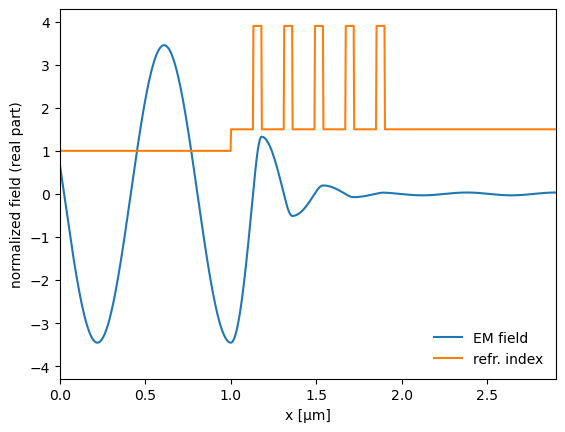

In [22]:
steps = 200
periods = 10
ani = timeanimation(x, f, index, steps, periods)

In [24]:
from IPython.display import HTML
HTML(ani.to_html5_video())

# if this throws a runtime error, try:
# conda install -c conda-forge ffmpeg